In [35]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import textblob, string
import requests
import re
import sys
import stat
from lxml import html
import xlrd
from tika import parser
from nltk import tokenize
from collections import OrderedDict
import seaborn as sns

from sklearn import model_selection, preprocessing, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB

import nltk  
nltk.download('stopwords') 
import pickle  
from nltk.corpus import stopwords  

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rushikesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Data Crawler**

In [2]:
# This script is used for automatically download and save pdfs from 
# MassDEP website with specified RTN-submit time pairs
# Author @Ethan 2018

# To run the script
# In Shell:
# python3 crawler.py <full_name_of_TSAUD_file.xlsx>
# If run in notebook:
# Change TSAUD_file to <full_name_of_TSAUD_file.xlsx> instead


def Data_Crawler(TSAUD_FILE , Directory_Name):
## Constants
    TSAUD_file = TSAUD_FILE #str(sys.argv[1]) # TSAUD file for rtn and time pairs, to run in notebook, use TSAUD_file = 'actual file name of TSAUD.xlsx'
    
    #Enter TSAUD FILE
    
    CURR_DIR_NAME = os.fsencode(Directory_Name) # current directory name  _____ Function
    CURR_DIR_NAME = CURR_DIR_NAME.decode()
    URL_REQUEST_PREFIX = "http://eeaonline.eea.state.ma.us/EEA/fileviewer/" # url prefix
    TABLE_ROW_RECORDS_TEXT = '''//tr[@id='UltraWebTab1xxctl0xGrid_r_{0}']//text()''' # table row regex
    TABLE_ROW_RECORDS_HREF = '''//tr[@id='UltraWebTab1xxctl0xGrid_r_{0}']//@href'''
    FORM_NAME_PREFIX = "BWSC105 Immediate Response Action"
    SUBMIT_RAW_TIME_FORMAT = re.compile(r'[0-9]+/[0-9]+/[0-9]{4}')
    SUBMIT_TIME_FORMAT = re.compile(r'[0-9]+-[0-9]+-[0-9]{4}')

## Test query
#QUERY_TEST = '2-020220'
#TIME_TEST = '8-10-2017'


    def get_html(query):
        '''
        Get HTTP response with query
    
        Argument
        query: rtn no.
        Return
        reponse: html page object
        '''
        response = ""
        try:
            response = requests.get(URL_REQUEST_PREFIX + "Rtn.aspx?rtn=" + query)
        except Exception:
            print("Cannot get response for query: {0}.".format(query))

        return response


    def parse_html_response(response):
        '''
        Parsing html response into DOM tree structures
        Argument
        response: html format response
        Return
        tree: DOM tree object
        '''
        try:
            tree = html.fromstring(response.content)
        except Exception:
            return {}
        return tree


    def create_folder(name):
        '''
        Create folder with provide name in current directory
        Change previlage of current folder with read, write and execute
        Argument
        name: name of folder in format of <rtn no.>_mm-dd-yyyy
        '''
        if name is None:
            return

        if os.path.isdir(CURR_DIR_NAME + "/" + name):
            return

        try:
            os.mkdir(name)
        except Exception:
            print("Cannot create folder {0}".format(name))


    def get_records(tree):
        '''
        Search DOM tree with table row information
        Filter out row records when the form is BWSC105
        Return the corresponding text and links for pdfs
        Argument
        tree: DOM tree parsed from html response
        Return
        rows_text: list of <list of unicodes> text parsed from rows
        rows_href: list of <list of unicodes> links parsed from rows
        '''
        index = 0
        rows_text = []
        rows_href = []

        while True:
            text = []
            href = []
            try:
                text = tree.xpath(TABLE_ROW_RECORDS_TEXT.format(index))
                href = tree.xpath(TABLE_ROW_RECORDS_HREF.format(index))
            except Exception:
                print("Not able to get rows")

            if len(text) == 0 or text is None:
                break

            if text[1].startswith(FORM_NAME_PREFIX):
                rows_text.append(text)
                rows_href.append(href)

            index += 1

        return rows_text, rows_href


    def check_time_match(text, time):
        '''
        Check if query rtn result has the matched submit time
        Two conditions:
            1. Time exactly matches
            2. Only year matches
        Argument
        text: text record in a row
        time: required time stamp
        Return
        flg: indicator on whether time matches
        time_result: real submit time from website
        '''
         #if text is None:
         #   return False, None
        for i in range(2,9):
            try:
                submit_time_raw_text = text[i]
                time_result = re.match(SUBMIT_RAW_TIME_FORMAT, submit_time_raw_text).group(0)
                time_result = time_result.replace('/', '-')

                record_date = time_result.split('-')
                required_date = time.split('-')


                if time_result == time: # Entire time matches
                    return True, time_result
                elif record_date[2] == required_date[2]: # Year matches
                    return True, time_result
            except Exception:
                pass
        return False, None


    def download_save_pdf(text, href, folder_name, submit_real):
        '''
        Match IRA with its link
        It downloads pdfs whose link must contain word 'IRA'.
        Argument
        text: list of text in the row record
        href: all the url in the row record
        folder_name: folder to save pdf
        '''
        tmp = []
        count = 1
        for s in text[3:]:
            if s.endswith('.pdf') and ('IRA' in s):
                tmp.append(count)
                count += 1

        for index in tmp:
            if index < len(href):
                pdf_link = href[index]
                pdf = requests.get(URL_REQUEST_PREFIX + pdf_link)
                #folder_name + "/" = after curr_dir_name + "/"
                with open(CURR_DIR_NAME + "/"  + rtn + "_" + time+ "_" + submit_real + "_report.pdf", "wb") as f:
                    f.write(pdf.content)


    def open_xlsx_rtn_time_list():
        '''
        Open excel file that contains required rtn_time list
        Return 
        rtns_submitTime: a dict key = rtn and value = submit time
        '''
        workbook = xlrd.open_workbook(TSAUD_FILE)
        sheet = workbook.sheet_by_index(0)
        rtns_submitTime = {} # index 0 and 1

        for rowx in range(1, sheet.nrows):
            col = sheet.row_values(rowx)
            rtn = str(col[0])
            #print(col[1].split())
            submit_time = re.match(SUBMIT_TIME_FORMAT, col[1].split()[-1]).group(0)
            rtns_submitTime[rtn] = str(submit_time)

        return rtns_submitTime


    ## Main
    if __name__ == "__main__":
        # Get rtn list needs to query from MassDEP
        rtns_submitTime = open_xlsx_rtn_time_list()


        for rtn, time in rtns_submitTime.items():
            # Create folders under the same directory
            name = rtn + "_" + time
            #create_folder(name)

            # Send HTTP
            response = get_html(rtn)
            tree = parse_html_response(response)
            text_list, href_list = get_records(tree) # texts and hrefs match BWSC105

            for text, href in zip(text_list, href_list):
                flg, submit_real = check_time_match(text, time)
                #Save Pdfs to local disk. 
                if flg:
                    download_save_pdf(text, href, name, submit_real)




In [8]:
Data_Crawler('D:/Massdep/Input Data Final/Negative FIles/TSAUD_N.xlsx', 'D:/Massdep/Input Data Final/Negative FIles')

KeyboardInterrupt: 

**Data Cleaning**

In [8]:
#1. 
def Data_Cleaning(Directory_Name):
    directory = os.chdir(Directory_Name)

    for file in os.listdir(directory):
        filename = os.fsdecode(file)

    #2.    

        if filename.endswith(".pdf"): 
                #filename = 'IRAS #5 Hammond.pdf'
                raw = parser.from_file(filename)
                df = (raw["content"])
                df= df.strip("\n")
                df = df.lstrip("\n")
                df=df.rstrip("\n")
                df=df.replace("\n", " ")
                df = df.encode('ascii', 'ignore')
                df = str(df, 'utf-8')
    #3.             
                patt = re.compile('(\s*)\U0000F0B7(\s*)')
                df = patt.sub(' ', df)
                df = re.sub(r'^https?:\/\/.*[\r\n]*', '', df, flags=re.MULTILINE)
                df = re.sub(r'^http?:\/\/.*[\r\n]*', '', df, flags=re.MULTILINE)
                df = re.sub(r'^www?:\/\/.*[\r\n]*', '', df, flags=re.MULTILINE)
                df= ''.join(c for c in df if c not in "(){}?\;:_+=^&*%$#@!~`|")
                df = df.replace("\"", "")
                df = df.replace("/", " ")
                df = df.replace("-", " ")
    #4. 
                df = re.sub(r'\b[A-Z]+\b','', df)
                df = re.sub("\d+\.\d+",'', df)
                df = " ".join(df.split())

        #5. Indoor Air
                list27 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('• ') or str1.split('.” ')) if ('indoor air') in sentence]
    #6. Groundwater
                list1 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ')  or df.split('.” ')) if ('ground water') in sentence]
                list2 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('groundwater') in sentence]
                list3 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ')  or df.split('.” ')) if ('Groundwater') in sentence]
                list28 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ')  or df.split('.” ')) if ('Ground water') in sentence]
    #7. Within 15 or 30 feet
                list4 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('within 15 feet') in sentence]
                list5 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('within fifteen feet') in sentence]
                list6 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('within 30 feet') in sentence]
                list7 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('within thirty feet') in sentence]
                list8 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('Within fifteen feet') in sentence]
                list9 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('Within thirty feet') in sentence]
                list10 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ("<15'") in sentence]
                list11= [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ("<30'") in sentence]
    #8. Resident or commercial air}
                list12 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('residential air') in sentence]
                list13 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('commercial air') in sentence]
    #9. Soil gas
                list14 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('soil gas') in sentence]
    #10. Testing private residential municipal generic terms - Looks good
                list15 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('private') in sentence]
                list16 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('residential') in sentence]
                list17 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('public') in sentence]
                list18 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('municipal') in sentence]
    #11. Critical Pathway exposure
                list19 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('critical exposure pathway') in sentence]
    #12. NAPL
                list21 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('Nonaqueous') in sentence]
                list22 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('NAPL') in sentence]
                list23 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('LNAPL') in sentence]
                list24 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('Non-aqueous') in sentence]
                list25 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('nonaqueous') in sentence]
                list26 = [sentence + '. ' for sentence in (df.split('. ') or df.split('; ') or df.split('.” ')) if ('non-aqueous') in sentence]
    #13. Bringing all together. Removing duplicate sentences and adding it to the corpus.
                final_corpus = list1 + list2 + list3 + list4 + list5 + list6 +list7 + list8+ list10 + list11 + list12 + list13 + list14 + list15 + list16 + list17 + list18 +list19 +list21+list22 + list23+list24+list25 +list26 + list27 + list28
                final_corpus =  list(OrderedDict.fromkeys(final_corpus))
                str1 = ''.join(final_corpus)
                str1 = re.sub(',', ' ', str1)

    #14. Removing Addresses
                address_pat = re.compile(r'\d{1,4} [\w\s]{1,20}(?:street|st|avenue|ave|road|rd|highway|hwy|square|sq|trail|trl|drive|dr|court|ct|parkway|pkwy|circle|cir|boulevard|blvd)\W?(?=\s|$)',re.IGNORECASE)
                str1 = address_pat.sub(' ', str1)
    #15. Removing dates and alpha numeric characters and removing <

                date_1 = re.compile('\d{2}/\d{2}/\d{4}')
                str1 = date_1.sub(' ', str1)
                date_3 = re.compile('[A-Z][a-z]{0,10}\s\d{0,2}\s\d{4}',re.IGNORECASE)
                str1 = date_3.sub(' ', str1)
                date_3 = re.compile('[A-Z][a-z]{0,10}\s\d{4}',re.IGNORECASE)
                str1 = date_3.sub(' ', str1)
                new_s = ""
                for word in str1.split(' '):
                                if any(char.isdigit() for char in word) and any(c.isalpha() for c in word):
                                    new_s += ''.join([i for i in word if not i.isdigit()])
                                else:
                                    new_s += word
                                new_s += ' '
                str1 = new_s
                str1 = str1.replace('–', ' ')
                str1 = str1.replace('<', '')
                str1 = re.sub(r'\b[A-Z]+\b','', str1)
                str1 = " ".join(str1.split())

    #16. Remove numbers from String

                str1 = ''.join([i for i in str1 if not i.isdigit()])
                str1 = " ".join(str1.split())

    #24. Remove 2 lettered words

                shortword = re.compile(r'\W*\b\w{1,2}\b')
                str1 = shortword.sub('', str1)

    #17. Impact keyword

                list1 = [sentence + '. ' for sentence in (str1.split('. ') or str1.split('; ') or str1.split('.') or str1.split(' .') or str1.split('• ') or str1.split('.” ')) if ('impact') in sentence]
    #18. NAPL

                list2 = [sentence + '. ' for sentence in (str1.split('. ') or str1.split('; ') or str1.split('.') or str1.split(' .') or str1.split('.” ')) if ('Nonaqueous') in sentence]
                list3 = [sentence + '. ' for sentence in (str1.split('. ') or str1.split('; ') or str1.split('.') or str1.split(' .') or str1.split('.” ')) if ('NAPL') in sentence]
                list4 = [sentence + '. ' for sentence in (str1.split('. ') or str1.split('; ') or str1.split('.') or str1.split(' .') or str1.split('.” ')) if ('LNAPL') in sentence]
                list5 = [sentence + '. ' for sentence in (str1.split('. ') or str1.split('; ') or str1.split('.') or str1.split(' .') or str1.split('.” ')) if ('Non-aqueous') in sentence]
                list6 = [sentence + '. ' for sentence in (str1.split('. ') or str1.split('; ') or str1.split('.') or str1.split(' .') or str1.split('• ') or str1.split('.” ')) if ('non-aqueous') in sentence]

    #19. Affect
                list7 = [sentence + '. ' for sentence in (str1.split('. ') or str1.split('; ') or str1.split('.') or str1.split(' .') or str1.split('.” ')) if ('affect') in sentence]
                list8 = [sentence + '. ' for sentence in (str1.split('. ') or str1.split('; ') or str1.split('.') or str1.split(' .') or str1.split('.” ')) if ('Affect') in sentence]
    #20. Contaminate
                list9 = [sentence + '. ' for sentence in (str1.split('. ') or str1.split('; ') or str1.split('.') or str1.split(' .') or str1.split('.” ')) if ('contaminat') in sentence]
    #21. Pollute
                list10 = [sentence + '. ' for sentence in (str1.split('. ') or str1.split('; ') or str1.split('.') or str1.split(' .') or str1.split('• ') or str1.split('.” ')) if ('pollut') in sentence]
    #22. Exceed
                list11 = [sentence + '. ' for sentence in (str1.split('. ') or str1.split('; ') or str1.split('.') or str1.split(' .') or str1.split('.” ')) if ('exceed') in sentence]

    #23. Hazard
                list12 = [sentence + '. ' for sentence in (str1.split('. ') or str1.split('; ') or str1.split('.') or str1.split(' .') or str1.split('• ') or str1.split('.” ')) if ('hazard') in sentence]
                list13 = [sentence + '. ' for sentence in (str1.split('. ') or str1.split('; ') or str1.split('.') or str1.split(' .') or str1.split('• ') or str1.split('.” ')) if ('nonaqueous') in sentence]

    #Bringing it all together and then merging the corpus

                final_corpus = list1 + list2 + list3 + list4 + list5 + list6 +list7 + list8 + list9 + list10 + list11 + list12 + list13
                final_corpus =  list(OrderedDict.fromkeys(final_corpus))
                str2 = ' '.join(final_corpus)

    #Generating output in txt format

                output = open('out_{0}.txt'.format(filename), 'wb')
                output.write(str(str2).encode("utf-8"))
                output.close()

In [11]:
Data_Cleaning('D:/Massdep/Input Data Final/Positive FIles')

In [15]:
SEED = 2000
os.chdir('D:/Massdep/Input Data Final/Positive FIles/Y')
documents = []
for file in glob.glob("*.txt"): # read all txt files in working directory
    file_content = open(file, "r")
    lines = file_content.read().splitlines()
    for line in lines:
        documents.append(line)

data = pd.DataFrame({'Documents': documents, 'Label': 1})


os.chdir('D:/Massdep/Input Data Final/Negative FIles/N')
documents1 = []
for file in glob.glob("*.txt"): # read all txt files in working directory
    file_content = open(file, "r")
    lines = file_content.read().splitlines()
    for line in lines:
        documents1.append(line)

data1 = pd.DataFrame({'Documents': documents1, 'Label': 0})


data = data.append(data1)

data['Documents'].replace('', np.nan, inplace=True)

data.dropna(subset=['Documents'], inplace=True)

#split the dataset into training and validation datasets 
train_x, test_x, train_y, test_y = model_selection.train_test_split(data['Documents'], data['Label'])
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(train_x, train_y, test_size=.2, random_state=SEED)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
test_y  = encoder.fit_transform(test_y)

print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(train_x),(len(train_x[train_y == 0]) / (len(train_x)*1.))*100,  (len(train_x[train_y == 1]) / (len(train_x)*1.))*100))
print ("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(valid_x),(len(valid_x[valid_y == 0]) / (len(valid_x)*1.))*100,(len(valid_x[valid_y == 1]) / (len(valid_x)*1.))*100))
print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(test_x),(len(test_x[test_y == 0]) / (len(test_x)*1.))*100, (len(test_x[test_y == 1]) / (len(test_x)*1.))*100))

Train set has total 333 entries with 72.67% negative, 27.33% positive
Validation set has total 84 entries with 65.48% negative, 34.52% positive
Test set has total 140 entries with 75.71% negative, 24.29% positive


**Count Vectorizer + Logistic Regression**

In [44]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(train_x) + list(valid_x))
xtrain_ctv =  ctv.transform(train_x) 
xvalid_ctv = ctv.transform(valid_x)
xtest_ctv = ctv.transform(test_x)

smt = SMOTE(random_state=777, k_neighbors=1)
X_SMOTE, y_SMOTE = smt.fit_sample(xtrain_ctv, train_y)
smote = pd.DataFrame(X_SMOTE.todense(), columns=ctv.get_feature_names())

# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, train_y)
predictions = clf.predict(xvalid_ctv)

print ("accuracy: %0.3f " % accuracy_score(valid_y, predictions))
cm = confusion_matrix(valid_y, predictions)
print(cm)

accuracy: 0.738 
[[49  6]
 [16 13]]


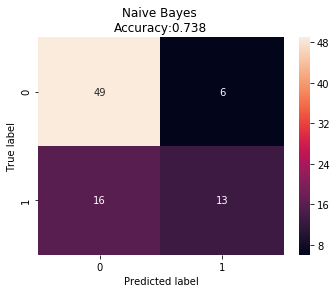

In [45]:
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Naive Bayes \nAccuracy:{0:.3f}'.format(accuracy_score(valid_y, predictions)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Results on Test Set**

In [30]:
predictions = clf.predict(xtest_ctv)
print ("accuracy: %0.3f " % accuracy_score(test_y, predictions))
cm = confusion_matrix(test_y, predictions)
print(cm)

accuracy: 0.714 
[[86 20]
 [20 14]]


**Naive Bayes + SMOTE + Count Vectorizer**

In [46]:
# Fitting a simple Naive Bayes on Counts

smt = SMOTE(random_state=777, k_neighbors=1)
X_SMOTE, y_SMOTE = smt.fit_sample(xtrain_ctv, train_y)
smote = pd.DataFrame(X_SMOTE.todense(), columns=ctv.get_feature_names())

clf = MultinomialNB()
clf.fit(X_SMOTE, y_SMOTE)
predictions = clf.predict(xvalid_ctv)

print ("Accuracy: %0.3f " % accuracy_score(valid_y, predictions))
cm = confusion_matrix(valid_y, predictions)
print(cm)

Accuracy: 0.738 
[[41 14]
 [ 8 21]]


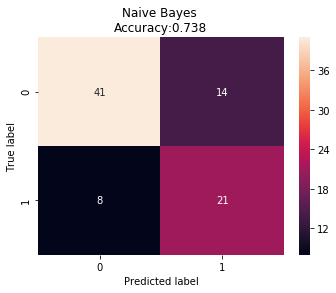

In [47]:
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Naive Bayes \nAccuracy:{0:.3f}'.format(accuracy_score(valid_y, predictions)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Results on Test Set**

In [33]:
predictions = clf.predict(xtest_ctv)
print ("accuracy: %0.3f " % accuracy_score(test_y, predictions))
cm = confusion_matrix(test_y, predictions)
print(cm)

accuracy: 0.679 
[[77 29]
 [16 18]]
